In [2]:
import sys
import os
sys.path.append("../") 
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
#import geopandas as gpd
from exploratory_data_analysis import omnivida_loader as ov
from exploratory_data_analysis import omnivida_util as ovu
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus
import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

In [140]:
_, adherence_change = ov.get_adherence_dataset()
adherence, adherence_change = ov.get_adherence_dataset()
dyspnea = ov.get_dyspnea_dataset()
act_disag = ov.get_act_disag_dataset()
act = ov.get_act_dataset()
vacc = ov.get_vaccination_dataset()

In [141]:
act_disag.drop(columns=['Unnamed: 0'], axis = 1, inplace=True)
dyspnea.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)
act.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)
vacc.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)

In [142]:
dyspnea_cp = dyspnea.copy()
act_disag_cp = act_disag.copy()
act_cp = act.copy()
vacc_c = vacc.copy()

In [143]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'qualitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage', 'num_reports']
adherence_change_analysis = adherence_change[select_fields]

#### Organizing dataset

In [144]:
# Dyspnea dataset
dyspnea_cp.medical_test = dyspnea_cp.medical_test.astype(int)

In [145]:
# act_disag dataset
act_disag_cp.A_ACT = act_disag_cp.A_ACT.astype(int)
act_disag_cp.B_ACT = act_disag_cp.B_ACT.astype(int)
act_disag_cp.C_ACT = act_disag_cp.C_ACT.astype(int)
act_disag_cp.D_ACT = act_disag_cp.D_ACT.astype(int)
act_disag_cp.FEEDBACK = act_disag_cp.FEEDBACK.astype(int)

In [146]:
# Act dataset
act_cp.act_score = act_cp.act_score.astype(int)
act_cp.result = act_cp.result.astype(int)

In [147]:
# Vaccination dataset
select_fields_vacc = ['id_patient', 'emission_date', 'regional_eps', 'service_description', 'diagnostic_eps_description', 'auth_quantity']
vacc_cp = vacc_c[select_fields_vacc]
vacc_cp['regional_eps'] = vacc_cp['regional_eps'].astype('category')
vacc_cp['service_description'] = vacc_cp['service_description'].astype('category')
vacc_cp['diagnostic_eps_description'] = vacc_cp['diagnostic_eps_description'].astype('category')
vacc_cp.auth_quantity = vacc_cp.auth_quantity.astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Dyspnea + adherence_change_analysis dataset

In [148]:
adherence_11 = adherence_change_analysis.merge(dyspnea_cp, how='left', on='id_patient')

#### PART 1 : Merging datasets using function

In [149]:
# Merging adherence and dyspnea_cp
merge_adh_dysp = ovu.merge_on_closest_date(df1=adherence_change_analysis, 
                                          df2=dyspnea_cp, 
                                          date_field_df1='survey_date', 
                                          date_field_df2='discharge_date', 
                                          merge_on='id_patient')
merge_adh_dysp

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,days_since_discharge_date,discharge_date,medical_test
0,524006,2015-09-10,A-,1.0,0.0,248.0,100.000000,2,0.0,2015-09-10,4
1,524006,2015-10-13,A-,0.0,-1.0,33.0,66.666667,3,33.0,2015-09-10,4
2,524006,2015-11-09,A-,0.0,0.0,27.0,50.000000,4,60.0,2015-09-10,4
3,524006,2016-06-02,A-,1.0,1.0,206.0,60.000000,5,266.0,2015-09-10,4
4,524006,2016-10-07,A-,1.0,0.0,127.0,66.666667,6,0.0,2016-10-07,3
...,...,...,...,...,...,...,...,...,...,...,...
538,1828862,2019-07-23,N+,0.0,0.0,57.0,40.909091,22,839.0,2017-04-05,1
539,1828862,2020-03-03,N+,0.0,0.0,224.0,39.130435,23,1063.0,2017-04-05,1
540,1998401,2016-06-02,A-,0.0,0.0,129.0,70.000000,10,0.0,2016-06-02,0
541,1998401,2016-09-12,A-,0.0,0.0,102.0,63.636364,11,102.0,2016-06-02,0


In [150]:
merge_adh_dysp.rename(columns={'days_since_discharge_date':'days_since_last_dyspnea_test'}, inplace=True)

period = 30
aclq_timely = merge_adh_dysp[merge_adh_dysp.days_since_last_dyspnea_test <= period]
aclq_late = merge_adh_dysp[merge_adh_dysp.days_since_last_dyspnea_test > period]
aclq_timely

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,days_since_last_dyspnea_test,discharge_date,medical_test
0,524006,2015-09-10,A-,1.0,0.0,248.0,100.000000,2,0.0,2015-09-10,4
4,524006,2016-10-07,A-,1.0,0.0,127.0,66.666667,6,0.0,2016-10-07,3
6,524006,2017-01-27,A-,1.0,0.0,80.0,75.000000,8,0.0,2017-01-27,1
8,524006,2017-05-10,A-,0.0,-1.0,28.0,70.000000,10,0.0,2017-05-10,1
10,524006,2017-08-25,A-,1.0,0.0,28.0,75.000000,12,0.0,2017-08-25,1
...,...,...,...,...,...,...,...,...,...,...,...
508,1764814,2017-04-26,A,1.0,0.0,58.0,93.333333,15,0.0,2017-04-26,2
509,1764814,2017-05-10,A,1.0,0.0,14.0,93.750000,16,14.0,2017-04-26,2
515,1801732,2015-07-02,M,0.0,-1.0,92.0,50.000000,2,0.0,2015-07-02,1
526,1828862,2017-04-05,N+,0.0,-1.0,27.0,60.000000,10,0.0,2017-04-05,1


In [151]:
aclq_timely_summary = pd.DataFrame()
for (patient, survey_date), df in aclq_timely.groupby(['id_patient', 'survey_date']):
    aclq_timely_summary = aclq_timely_summary.append({
                'id_patient': patient,
                'survey_date': survey_date,
                'medical_test': df.medical_test.sum(),
                'days_since_last_dyspnea_test': df.iloc[-1]['days_since_last_dyspnea_test']
            }, ignore_index=True)

aclq_timely_summary

,days_since_last_dyspnea_test,id_patient,medical_test,survey_date
0,0.0,524006.0,4.0,2015-09-10
1,0.0,524006.0,3.0,2016-10-07
2,0.0,524006.0,1.0,2017-01-27
3,0.0,524006.0,1.0,2017-05-10
4,0.0,524006.0,1.0,2017-08-25
...,...,...,...,...
99,0.0,1764814.0,2.0,2017-04-26
100,14.0,1764814.0,2.0,2017-05-10
101,0.0,1801732.0,1.0,2015-07-02
102,0.0,1828862.0,1.0,2017-04-05


In [152]:
# Merging adherence with aclq_timely_summary 
merge_adh_dysp = adherence_change_analysis.merge(aclq_timely_summary, how='left', on=['id_patient', 'survey_date'])
merge_adh_dysp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 0 to 4772
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4773 non-null   int64         
 1   survey_date                   4773 non-null   datetime64[ns]
 2   category                      4773 non-null   category      
 3   qualitative_result            4773 non-null   float64       
 4   qualitative_result_change     3933 non-null   float64       
 5   days_since_last_control       3933 non-null   float64       
 6   ongoing_adherence_percentage  4773 non-null   float64       
 7   num_reports                   4773 non-null   int64         
 8   days_since_last_dyspnea_test  104 non-null    float64       
 9   medical_test                  104 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(6), int64(2)
memory usage: 377.7 KB


In [153]:
merge_adh_dysp['qualitative_result_change'] = merge_adh_dysp['qualitative_result_change'].fillna(0)
merge_adh_dysp['days_since_last_control'] = merge_adh_dysp['days_since_last_control'].fillna(0)
merge_adh_dysp['days_since_last_dyspnea_test'] = merge_adh_dysp['days_since_last_dyspnea_test'].fillna(0)
merge_adh_dysp['medical_test'] = merge_adh_dysp['medical_test'].fillna(0)

In [154]:
merge_all_dyspnea = merge_adh_dysp.copy()
merge_all_dyspnea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 0 to 4772
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4773 non-null   int64         
 1   survey_date                   4773 non-null   datetime64[ns]
 2   category                      4773 non-null   category      
 3   qualitative_result            4773 non-null   float64       
 4   qualitative_result_change     4773 non-null   float64       
 5   days_since_last_control       4773 non-null   float64       
 6   ongoing_adherence_percentage  4773 non-null   float64       
 7   num_reports                   4773 non-null   int64         
 8   days_since_last_dyspnea_test  4773 non-null   float64       
 9   medical_test                  4773 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(6), int64(2)
memory usage: 377.7 KB


#### Part 2: adherence + act datasets

In [155]:
act_disag_cp.rename(columns={'result_date':'date_result'}, inplace = True)
act_disag_cp.shape
act_disag_cp

,id_patient,date_result,A_ACT,B_ACT,C_ACT,D_ACT,FEEDBACK
0,535255,2012-06-29,0,0,2,0,0
1,535255,2012-06-29,0,2,0,0,0
2,535255,2012-06-29,4,0,0,0,0
3,535255,2012-06-29,0,0,0,2,0
4,535255,2012-06-29,0,0,0,0,4
...,...,...,...,...,...,...,...
8570,744564,2020-05-20,0,0,2,0,0
8571,744564,2020-05-20,0,2,0,0,0
8572,744564,2020-05-20,1,0,0,0,0
8573,744564,2020-05-20,0,0,0,2,0


In [165]:
# Unite act and act_disaggregado in terms of date and id
#act_actDisagg = act_disag_cp.merge(act, how = 'left', on = ['id_patient'])
#print('act_actDisagg dimensions: ', act_actDisagg.shape)
# Merge adherence with both datasets:
merge_adh_act = ovu.merge_on_closest_date(df1=adherence_change_analysis, 
                                          df2=act_disag_cp, 
                                          date_field_df1='survey_date', 
                                          date_field_df2='date_result', 
                                          merge_on='id_patient')
print('merge_adh_act dimensions: ', merge_adh_act.shape)


merge_adh_act dimensions:  (13590, 15)


In [166]:
merge_adh_act.columns

Index(['id_patient', 'survey_date', 'category', 'qualitative_result',
       'qualitative_result_change', 'days_since_last_control',
       'ongoing_adherence_percentage', 'num_reports', 'days_since_date_result',
       'date_result', 'A_ACT', 'B_ACT', 'C_ACT', 'D_ACT', 'FEEDBACK'],
      dtype='object')

In [178]:
merge_adh_act.rename(columns={'days_since_date_result':'days_since_act_test'}, inplace=True)
period = 30
aclq_timely_act = merge_adh_act[merge_adh_act.days_since_act_test <= period]
aclq_late_act = merge_adh_act[merge_adh_act.days_since_act_test > period]
print(aclq_timely_act.shape)
aclq_timely_act

(4800, 15)


,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,days_since_act_test,date_result,A_ACT,B_ACT,C_ACT,D_ACT,FEEDBACK
0,502989,2014-10-28,M,0.0,0.0,67.0,0.0,2,0.0,2014-10-28,0,0,1,0,0
1,502989,2014-10-28,M,0.0,0.0,67.0,0.0,2,0.0,2014-10-28,0,1,0,0,0
2,502989,2014-10-28,M,0.0,0.0,67.0,0.0,2,0.0,2014-10-28,1,0,0,0,0
3,502989,2014-10-28,M,0.0,0.0,67.0,0.0,2,0.0,2014-10-28,0,0,0,1,0
4,502989,2014-10-28,M,0.0,0.0,67.0,0.0,2,0.0,2014-10-28,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,1999629,2018-10-08,A,1.0,0.0,157.0,100.0,3,13.0,2018-09-25,0,0,1,0,0
13586,1999629,2018-10-08,A,1.0,0.0,157.0,100.0,3,13.0,2018-09-25,0,1,0,0,0
13587,1999629,2018-10-08,A,1.0,0.0,157.0,100.0,3,13.0,2018-09-25,1,0,0,0,0
13588,1999629,2018-10-08,A,1.0,0.0,157.0,100.0,3,13.0,2018-09-25,0,0,0,1,0


In [204]:
aclq_timely_summary_act = pd.DataFrame()
for (patient, survey_date), df in aclq_timely_act.groupby(['id_patient', 'survey_date']):
    aclq_timely_summary_act = aclq_timely_summary_act.append({
        'id_patient': patient,
        'survey_date': survey_date,
        'days_since_act_test': df.iloc[-1]['days_since_act_test'],
       # 'act_score':df.iloc[-1]['act_score'],
        #'result': df.iloc[-1]['result'],
        'A_ACT': df.A_ACT.sum(),
        'B_ACT': df.B_ACT.sum(),
        'C_ACT': df.C_ACT.sum(),
        'D_ACT': df.D_ACT.sum(),
        'FEEDBACK': df.iloc[-1]['FEEDBACK'],      
        
    }, ignore_index=True)
print('aclq_timely_summary_act dimensions: ', aclq_timely_summary_act.shape)

merge_adh_ALL_act_dysp = merge_all_dyspnea.merge(aclq_timely_summary_act, how='left', on=['id_patient', 'survey_date'])    
print('merge_adh_ALL_act_dysp dimensions: ', merge_adh_ALL_act_dysp.shape)

aclq_timely_summary_act dimensions:  (948, 8)
merge_adh_ALL_act_dysp dimensions:  (4773, 16)


In [207]:
aclq_timely_summary_act

,A_ACT,B_ACT,C_ACT,D_ACT,FEEDBACK,days_since_act_test,id_patient,survey_date
0,1.0,1.0,1.0,1.0,4.0,0.0,502989.0,2014-10-28
1,1.0,1.0,1.0,1.0,4.0,24.0,502989.0,2014-11-21
2,3.0,1.0,2.0,2.0,4.0,0.0,502989.0,2017-01-03
3,2.0,2.0,2.0,2.0,5.0,8.0,502989.0,2018-10-03
4,1.0,1.0,2.0,1.0,4.0,14.0,506808.0,2018-10-08
...,...,...,...,...,...,...,...,...
943,3.0,2.0,3.0,5.0,3.0,0.0,1997065.0,2017-03-13
944,1.0,1.0,1.0,1.0,5.0,18.0,1997065.0,2018-10-09
945,1.0,1.0,1.0,1.0,5.0,0.0,1998401.0,2016-06-02
946,1.0,1.0,2.0,1.0,5.0,0.0,1999629.0,2018-05-04


In [208]:
merge_adh_ALL_act_dysp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 0 to 4772
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4773 non-null   int64         
 1   survey_date                   4773 non-null   datetime64[ns]
 2   category                      4773 non-null   category      
 3   qualitative_result            4773 non-null   float64       
 4   qualitative_result_change     4773 non-null   float64       
 5   days_since_last_control       4773 non-null   float64       
 6   ongoing_adherence_percentage  4773 non-null   float64       
 7   num_reports                   4773 non-null   int64         
 8   days_since_last_dyspnea_test  4773 non-null   float64       
 9   medical_test                  4773 non-null   float64       
 10  A_ACT                         949 non-null    float64       
 11  B_ACT                         

In [210]:
merge_adh_ALL_act_dysp['A_ACT'] = merge_adh_ALL_act_dysp['A_ACT'].fillna(0)
merge_adh_ALL_act_dysp['B_ACT'] = merge_adh_ALL_act_dysp['B_ACT'].fillna(0)
merge_adh_ALL_act_dysp['C_ACT'] = merge_adh_ALL_act_dysp['C_ACT'].fillna(0)
merge_adh_ALL_act_dysp['D_ACT'] = merge_adh_ALL_act_dysp['D_ACT'].fillna(0)
merge_adh_ALL_act_dysp['FEEDBACK'] = merge_adh_ALL_act_dysp['FEEDBACK'].fillna(0)
merge_adh_ALL_act_dysp['days_since_act_test'] = merge_adh_ALL_act_dysp['days_since_act_test'].fillna(0)
merge_adh_ALL_act_dysp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 0 to 4772
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4773 non-null   int64         
 1   survey_date                   4773 non-null   datetime64[ns]
 2   category                      4773 non-null   category      
 3   qualitative_result            4773 non-null   float64       
 4   qualitative_result_change     4773 non-null   float64       
 5   days_since_last_control       4773 non-null   float64       
 6   ongoing_adherence_percentage  4773 non-null   float64       
 7   num_reports                   4773 non-null   int64         
 8   days_since_last_dyspnea_test  4773 non-null   float64       
 9   medical_test                  4773 non-null   float64       
 10  A_ACT                         4773 non-null   float64       
 11  B_ACT                         

In [214]:
# Merging adherence and vaccination datasets  
merge_adh__med = ovu.merge_on_closest_date(df1=adherence_change_analysis, 
                                          df2=vacc, 
                                          date_field_df1='survey_date', 
                                          date_field_df2='emission_date', 
                                          merge_on='id_patient')
merge_adh__med.shape

(329, 16)

Text(0.5, 1, 'Correlation Matrix')

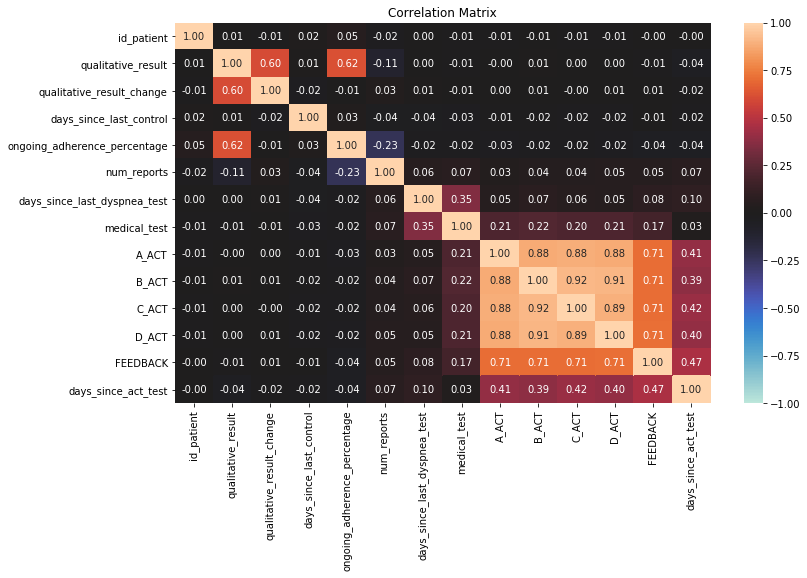

In [215]:
adherence_1_corr = merge_adh_ALL_act_dysp.corr()
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_1_corr, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [218]:
merge_modelable = merge_adh_ALL_act_dysp.copy()

In [220]:
merge_modelable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 0 to 4772
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_patient                    4773 non-null   int64         
 1   survey_date                   4773 non-null   datetime64[ns]
 2   category                      4773 non-null   category      
 3   qualitative_result            4773 non-null   float64       
 4   qualitative_result_change     4773 non-null   float64       
 5   days_since_last_control       4773 non-null   float64       
 6   ongoing_adherence_percentage  4773 non-null   float64       
 7   num_reports                   4773 non-null   int64         
 8   days_since_last_dyspnea_test  4773 non-null   float64       
 9   medical_test                  4773 non-null   float64       
 10  A_ACT                         4773 non-null   float64       
 11  B_ACT                         

In [269]:
merge_modelable['qualitative_result'].unique()

array([1., 0.])

Model training

In [221]:
def train(self):
    """Train two models: one Random forest classifier and one based on XGBoost"""
    if not self.rforest and not self.xgboost:
        covariates = self.data.columns[~self.data.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate', 'num_reports'])]
        print('> Training Random Forest classifier...')
        self.rforest = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)
        self.rforest.fit(self.data[covariates], self.data['qualitative_result'])
        y_pred_rf = self.rforest.predict(self.data[covariates])
        accuracy_rf = accuracy_score(self.data['qualitative_result'], y_pred_rf)
        print("> Done. Accuracy: %.2f%%" % (accuracy_rf * 100.0))

        print('> Training XGBoost classifier...')
        params={
            'reg_alpha': 23, 
            'max_depth': 8, 
            'learning_rate': 0.01, 
            'gamma': 1.0
        }
        self.xgboost = XGBClassifier(random_state=0, booster='gbtree', **params)
        self.xgboost.fit(self.data[covariates], self.data['qualitative_result'])
        y_pred_xg = self.xgboost.predict(self.data[covariates])
        predictions_xg = [round(value) for value in y_pred_xg]
        accuracy_xg = accuracy_score(self.data['qualitative_result'], predictions_xg)
        print("> Done. Accuracy: %.2f%%" % (accuracy_xg * 100.0))

    return (self.rforest, self.xgboost)

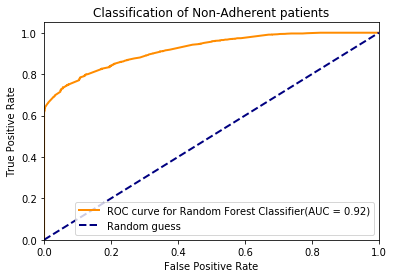

In [228]:
#Model using all covariates:

covariates1 = merge_modelable.columns[~merge_modelable.columns.isin(['id_patient', 
                                                                      'qualitative_result',
                                                                       'category',
                                                                       'survey_date',
                                                                    'days_since_last_control',
                                                                    'qualitative_result_change'])]
depth = 7

clf = DecisionTreeClassifier(max_depth = depth)
clf = clf.fit(merge_modelable[covariates1], merge_modelable['qualitative_result'])

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf.fit(merge_modelable[covariates1], merge_modelable['qualitative_result'])
clf_rf_probas = clf_rf.predict_proba(merge_modelable[covariates1])

roc_p = roc_curve(merge_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

In [224]:
covariates1

Index(['ongoing_adherence_percentage', 'num_reports',
       'days_since_last_dyspnea_test', 'medical_test', 'A_ACT', 'B_ACT',
       'C_ACT', 'D_ACT', 'FEEDBACK', 'days_since_act_test'],
      dtype='object')

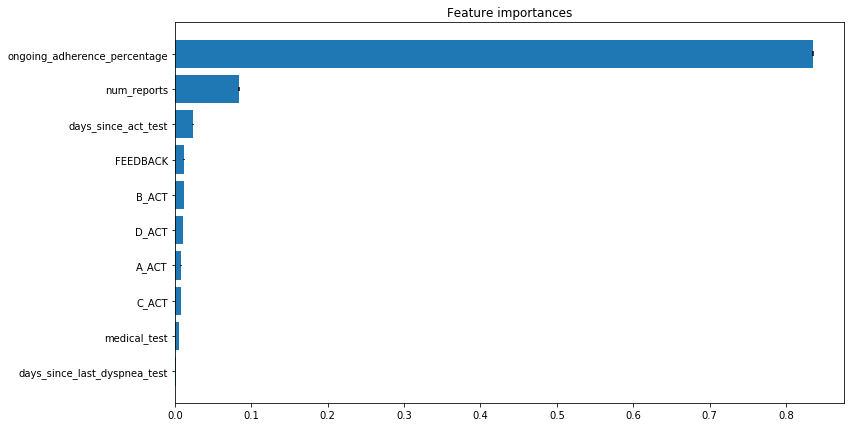

In [223]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(merge_modelable[covariates1].columns[indices], importances[indices], yerr=std[indices], align="center")
plt.show()

All covariates except num_reports

In [260]:
#covariates2 = merge_modelable.columns[~merge_modelable.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate', 'num_reports','days_since_last_control',
 #                                                                   'qualitative_result_change','category','ongoing_adherence_percentage'])]

covariates2 = merge_modelable.columns[~merge_modelable.columns.isin(['id_patient', 
                                                                      'qualitative_result',
                                                                       'category',
                                                                       'survey_date',
                                                                    'qualitative_result_change',
                                                                    'ongoing_adherence_percentage'])]

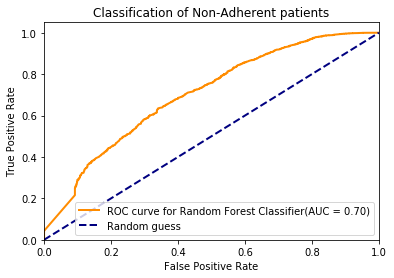

In [261]:
clf = DecisionTreeClassifier(max_depth = 7)
clf = clf.fit(merge_modelable[covariates2], merge_modelable['qualitative_result'])

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf.fit(merge_modelable[covariates2], merge_modelable['qualitative_result'])
clf_rf_probas = clf_rf.predict_proba(merge_modelable[covariates2])

roc_p = roc_curve(merge_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

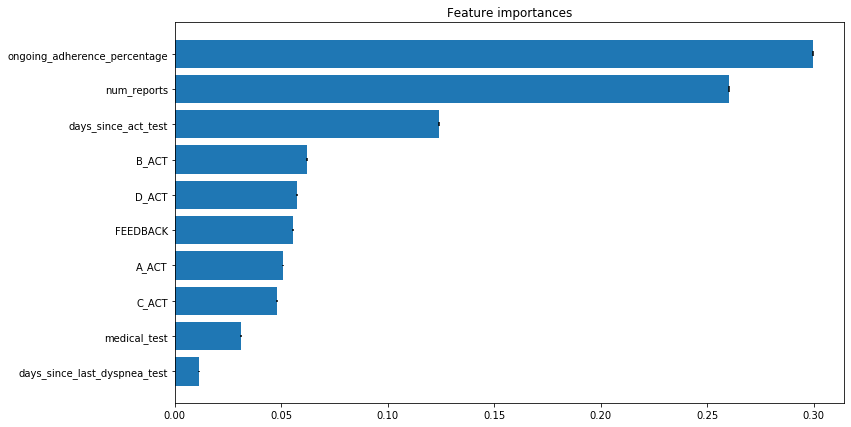

In [262]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(merge_modelable[covariates1].columns[indices], importances[indices], yerr=std[indices], align="center")
plt.show()

In [264]:
# Train and testing sets

merge_modelable_train = merge_modelable[merge_modelable['survey_date'] < "2020-01-01"]
merge_modelable_test = merge_modelable[merge_modelable['survey_date'] > "2019-12-31"]

display(merge_modelable_train.shape)
display(merge_modelable_test.shape)

(4392, 16)

(381, 16)

In [265]:
#Decision tree with covariates 1.
clf_new = DecisionTreeClassifier(max_depth = depth)
clf_new = clf_new.fit(merge_modelable_train[covariates1], merge_modelable_train['qualitative_result'])

y_pred_train = clf_new.predict(merge_modelable_train[covariates1])
y_pred_test = clf_new.predict(merge_modelable_test[covariates1])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_test)}")



Accuracy in training set: 0.8467668488160291
Accuracy in the other samples: 0.8818897637795275


In [266]:
#Decision tree with covariates 2.
clf_new2 = DecisionTreeClassifier(max_depth = depth)
clf_new2 = clf_new.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result'])

y_pred_train2 = clf_new.predict(merge_modelable_train[covariates2])
y_pred_test2 = clf_new.predict(merge_modelable_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_train2)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_test2)}")

Accuracy in training set: 0.7916666666666666
Accuracy in the other samples: 0.910761154855643


In [267]:
#Random forest with covariates 1.
clf_rf_new = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new.fit(merge_modelable_train[covariates1], merge_modelable_train['qualitative_result'])

y_pred_trainr = clf_rf_new.predict(merge_modelable_train[covariates1])
y_pred_testr = clf_rf_new.predict(merge_modelable_test[covariates1])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_trainr)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_testr)}")

Accuracy in training set: 0.8535974499089253
Accuracy in the other samples: 0.9186351706036745


In [268]:
#Random forest with covariates 2.
clf_rf_new2 = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new2.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result'])

y_pred_trainr2 = clf_rf_new2.predict(merge_modelable_train[covariates2])
y_pred_testr2 = clf_rf_new2.predict(merge_modelable_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(merge_modelable_train['qualitative_result'], y_pred_trainr2)}")
print(f"Accuracy in the other samples: {accuracy_score(merge_modelable_test['qualitative_result'], y_pred_testr2)}")

Accuracy in training set: 0.787568306010929
Accuracy in the other samples: 0.931758530183727


### xgboost

In [270]:
#fit model on training data with covariates 2.
xgb_model= XGBClassifier(max_depth=depth, random_state=0, booster='gbtree')
xgb_model.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [271]:
y_pred2 = xgb_model.predict(merge_modelable_test[covariates2])
predictions2 = [round(value) for value in y_pred2]

accuracy = accuracy_score(merge_modelable_test['qualitative_result'], predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.56%


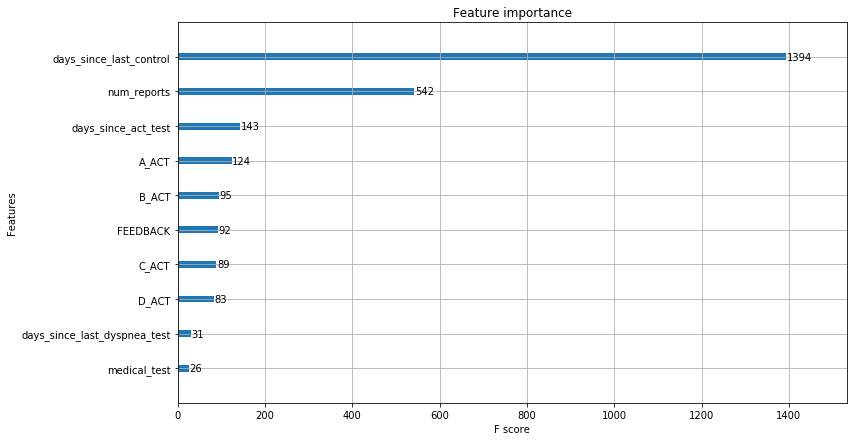

In [272]:
fig2, ax2 = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax2)

In [273]:
params_grid = {  
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'max_depth': [5,6,7,8,9,10,11,12],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    'reg_alpha': [20, 21, 22, 23, 24, 25]
}

search_sk = RandomizedSearchCV(xgb_model, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(merge_modelable_test[covariates1], merge_modelable_test['qualitative_result'])

# best parameters
print(search_sk.best_params_)
print(search_sk.best_score_)

{'reg_alpha': 21, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.8}
0.9344497607655502


In [274]:
xgb_model_new = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_new.fit(merge_modelable_train[covariates2], merge_modelable_train['qualitative_result']);

In [275]:
y_pred_new = xgb_model_new.predict(merge_modelable_test[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(merge_modelable_test['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.18%


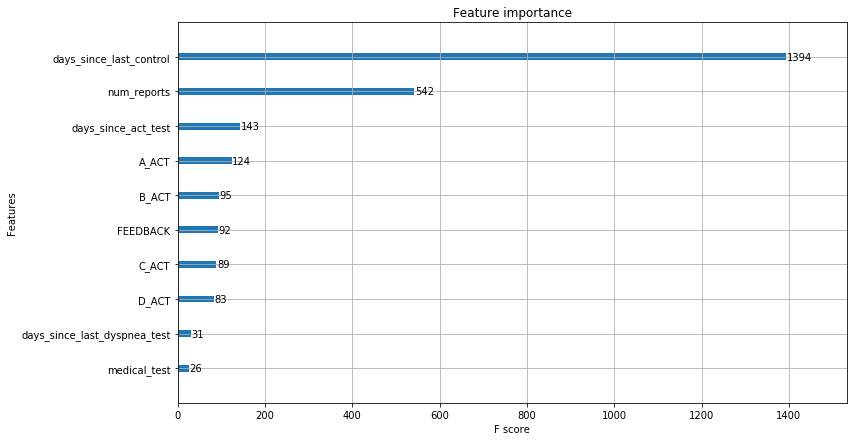

In [276]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax)

In [277]:
xgb_model_full = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_full.fit(merge_modelable[covariates2], merge_modelable['qualitative_result'])

y_pred_new = xgb_model_full.predict(merge_modelable[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(merge_modelable['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.30%


### Evaluate these three models with cross validation

In [278]:
def cv_roc_tree(X, y, n_split, algo='Tree', depth=10, params={}):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo == 'Tree':
            clf = DecisionTreeClassifier()
        elif algo == 'forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
        else:
            clf = XGBClassifier(random_state=0, booster='gbtree', verbosity=0, **params)
            
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

Text(0.5, 1.0, 'Tree-based Classification of Non-adherent patients: 5-fold Cross-validation')

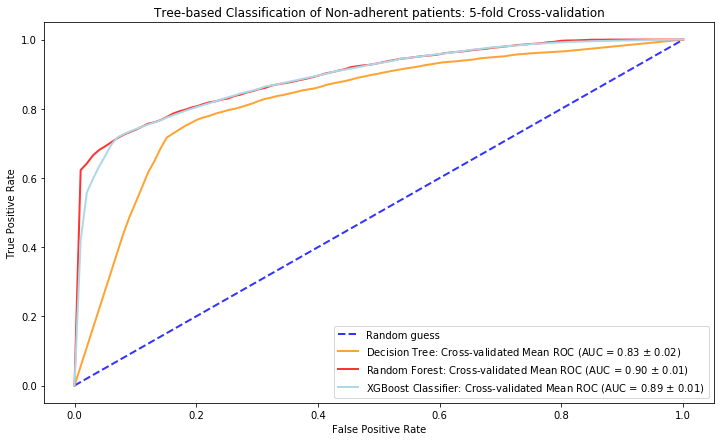

In [279]:
k_folds = 5
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree(merge_modelable[covariates1], merge_modelable['qualitative_result'], k_folds, depth=depth)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(merge_modelable[covariates1], merge_modelable['qualitative_result'], k_folds, algo='forest', depth=depth)
tprs_x, aucs_x, mean_fpr_x = cv_roc_tree(merge_modelable[covariates1], merge_modelable['qualitative_result'], k_folds, algo='xgboost', params=search_sk.best_params_)

plt.figure(figsize=(12,7))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_x = np.mean(tprs_x, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0
mean_tpr_x[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
mean_auc_x = auc(mean_fpr_x, mean_tpr_x)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)
std_auc_x = np.std(aucs_x)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange', lw=2, alpha=.8,
         label=f"Decision Tree: Cross-validated Mean ROC (AUC = {mean_auc_t:0.2f} $\pm$ {std_auc_t:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")
plt.plot(mean_fpr_x, mean_tpr_x, color='lightblue', lw=2, alpha=1.,
         label=f"XGBoost Classifier: Cross-validated Mean ROC (AUC = {mean_auc_x:0.2f} $\pm$ {std_auc_x:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title(f'Tree-based Classification of Non-adherent patients: {k_folds}-fold Cross-validation')